In [65]:
import pandas as pd
import numpy as np
import string
import random
import functools
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
team_w = ['PSG', 'Bayern', 'Man City', 'Juventus', 'Liverpool', 'Barcelona', 'RB Leipzig', 'Valencia']
team_r = ['Real Madrid', 'Spurs', 'Atalanta', 'Atletico', 'Napoli', 'Dortmund', 'Lyon', 'Chelsea']
team_w_country = ['FRA', 'GER', 'ENG', 'ITA', 'ENG', 'SPA', 'GER', 'SPA']
team_r_country = ['SPA', 'ENG', 'ITA', 'SPA', 'ITA', 'GER', 'FRA', 'ENG']
team_w_pos = ['Winner'] * 8
team_r_pos = ['Runner Up'] * 8
team_w_group = list(string.ascii_uppercase[0:8])
team_r_group = list(string.ascii_uppercase[0:8])

In [23]:
team_w_df = pd.DataFrame({
    'Key': 1,
    'Team': team_w, 
    'Country': team_w_country, 
    'Position': team_w_pos,
    'Group': team_w_group
        })

team_r_df = pd.DataFrame({
    'Key': 1,
    'Team': team_r, 
    'Country': team_r_country, 
    'Position': team_r_pos,
    'Group': team_r_group
        })

In [24]:
draws = pd.merge(team_w_df, team_r_df, on = 'Key')
fixture_ref = draws.copy()

In [25]:
draws = draws[draws['Country_x'] != draws['Country_y']]
draws = draws[draws['Group_x'] != draws['Group_y']].drop(['Key'], axis = 1)
draws = draws[["Team_x", "Team_y"]].reset_index().drop('index', axis = 1)

In [26]:
valid_draws = np.array(draws["Team_x"] + '_' + draws["Team_y"])

In [27]:
draw_outcomes = []
draws['cross_join_index'] = 1
for team, draw in draws.groupby('Team_x'):
    draw_outcomes.append(draw)

In [28]:
test = functools.reduce(lambda df1, df2: pd.merge(df1, df2, on = 'cross_join_index'), draw_outcomes)
test = test.drop('cross_join_index', axis = 1)
test.columns = [(i+1)//2 for i in range(1, 17, 1)]

In [29]:
fixture_array = test.values.reshape((5400000,2))
draw_master_list = pd.DataFrame(fixture_array)
draw_master_list['draw_id'] = [(i+8)//8 for i in range(0, 5400000, 1)]
draw_master_list = draw_master_list.rename(columns = {0: 'team_1', 1: 'team_2'})

In [52]:
#dml_filtered = draw_master_list.groupby('draw_id').filter(lambda x: x.team_2.value_counts().max() < 2)
#dml_filtered.to_csv('possible_outcomes.csv', index = False)
dml_filtered = pd.read_csv('possible_outcomes.csv')

In [53]:
#draws = draws.drop('cross_join_index', axis = 1)
dml_filtered['fixture'] = dml_filtered['team_1'] + '_' + dml_filtered['team_2']
dml_filtered = dml_filtered.set_index('draw_id')

In [55]:
sim = []

while len(sim) < 4000000:
    draw_pool = dml_filtered.copy()
    results = []

    for team in team_r:
        opponent_pool = draw_pool.loc[draw_pool['team_2'] == team]['team_1'].unique()
        team1 = np.random.choice(opponent_pool, 1)[0]

        fixture = team1 + '_' + team

        valid_draw_ids = np.unique(draw_pool.loc[draw_pool['fixture'] == fixture].index.values)
        draw_pool = draw_pool.loc[draw_pool.index.isin(valid_draw_ids)]

        results.append(fixture)
        sim.append(fixture)

In [56]:
draw_counts = pd.DataFrame({'fixture': sim})
draw_counts = pd.DataFrame(draw_counts['fixture'].str.split('_').tolist(), columns = ['team_1', 'team_2'])

In [58]:
#draw_counts.to_csv('draw_output_4m.csv', index = False)
#draw_output = pd.read_csv('draw_output.csv')
#draw_output = pd.read_csv('draw_output_4m.csv')

In [70]:
draw_counts1 = draw_counts.groupby(['team_1', 'team_2']).size().to_frame('count')
draw_counts1['probability'] = (draw_counts1['count']/500000).round(4)

In [71]:
draw_counts2 = draw_counts1.drop('count', axis = 1).reset_index()

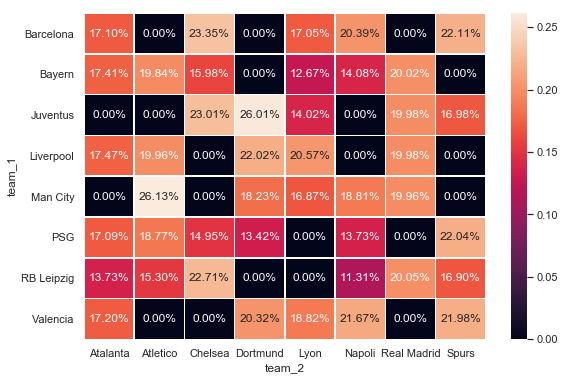

In [72]:
sns.set()

draw_counts_plot = draw_counts2.pivot("team_1", "team_2", "probability").fillna(0)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(draw_counts_plot, annot = True, fmt = ".2%", linewidths = .5, ax = ax)